In [14]:
import os
import random
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
from skimage.metrics import structural_similarity as ssim
import numpy as np

# Assuming the path to the dataset directory
dataset_path = "/home/me/stylegan3/data/FFHQ_52k/"
# dataset_path = "/home/me/stylegan3/data/celeba_hq/train/"
# dataset_path = "/home/me/stylegan3/data/afhq/train/"
dataset_path = "/home/me/stylegan3/data/metaface/"
dataset_path = "/home/me/stylegan3/data/cifar-10/"
# dataset_path = "/home/me/stylegan3/data/margot_robbie/"
# dataset_path = "/media/me/10.0TB/MyPhD/Datasets/CUB_200_2011/CUB_200_2011/images/"

class ImageDataset(Dataset):
    def __init__(self, root_dir, size=256, sample_size=500):
        self.transform = transforms.Compose([
            transforms.Resize((size, size)),
            transforms.ToTensor(),
        ])
        self.images = self._load_images(root_dir, sample_size)

    def _load_images(self, root_dir, sample_size):
        # Get all image file paths from subdirectories
        all_images = []
        for subdir in os.listdir(root_dir):
            subdir_path = os.path.join(root_dir, subdir)
            if os.path.isdir(subdir_path):
                all_images.extend([
                    os.path.join(subdir_path, file) 
                    for file in os.listdir(subdir_path) 
                    if file.lower().endswith(('.png', '.jpg', '.jpeg'))
                ])
        
        # Sample the images
        return random.sample(all_images, min(sample_size, len(all_images)))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        image = Image.open(image_path).convert('RGB')
        return self.transform(image)

# Function to calculate SSIM between two images
def calculate_ssim(image1, image2):
    # Convert tensors to numpy arrays
    img1 = image1.numpy().transpose(1, 2, 0)
    img2 = image2.numpy().transpose(1, 2, 0)

    # Convert to grayscale as SSIM is traditionally calculated on grayscale images
    img1_gray = np.dot(img1[..., :3], [0.2989, 0.5870, 0.1140])
    img2_gray = np.dot(img2[..., :3], [0.2989, 0.5870, 0.1140])

    return ssim(img1_gray, img2_gray, data_range=img1_gray.max() - img1_gray.min())

# Loading the dataset
dataset = ImageDataset(root_dir=dataset_path)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=4, pin_memory=True)

# Placeholder to store SSIM scores
ssim_scores = []

# Compare each image with another randomly selected image
for i, img1 in enumerate(dataloader):
    # Randomly select another image
    img2 = next(iter(dataloader))

    # Calculate SSIM and store
    score = calculate_ssim(img1[0], img2[0])
    ssim_scores.append(score)

# Average SSIM score
average_ssim = np.mean(ssim_scores)

average_ssim

0.3821263573289245

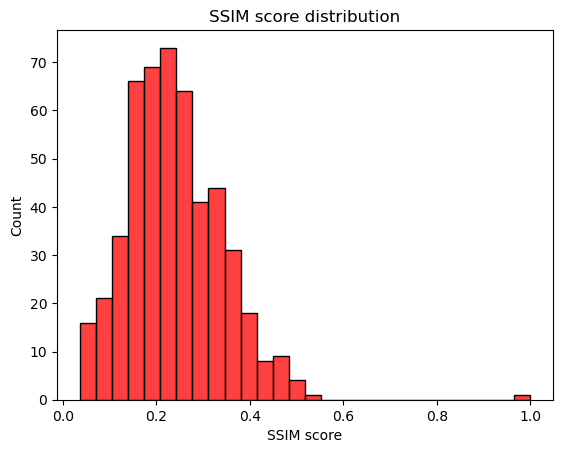

In [3]:
from matplotlib import pyplot as plt
import seaborn as sns

# Plot the distribution of SSIM scores
sns.histplot(ssim_scores, color='red' ,kde=False)
plt.xlabel('SSIM score')
plt.ylabel('Count')
plt.title('SSIM score distribution')
plt.show()


## Universal Diversity Distance (UDD)

In [13]:
import torch
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import random
import numpy as np
from scipy.spatial.distance import mahalanobis
from sklearn.decomposition import PCA

# Load InceptionV3
model = models.inception_v3(weights=True, transform_input=False)
model.fc = torch.nn.Identity()
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Assuming the path to the dataset directory
dataset_path = "/home/me/stylegan3/data/FFHQ_52k/"
# dataset_path = "/home/me/stylegan3/data/celeba_hq/train/"
# dataset_path = "/home/me/stylegan3/data/afhq/train/"
# dataset_path = "/home/me/stylegan3/data/margot_robbie/"
dataset_path = "/home/me/stylegan3/data/metaface/"
dataset_path = "/home/me/stylegan3/data/cifar-10/"
# dataset_path = "/media/me/10.0TB/MyPhD/Datasets/CUB_200_2011/CUB_200_2011/images/"

class ImageDataset(Dataset):
    def __init__(self, root_dir, size=512, sample_size=5000):
        self.transform = transforms.Compose([
            transforms.Resize((size, size)),
            transforms.ToTensor(),
        ])
        self.images = self._load_images(root_dir, sample_size)

    def _load_images(self, root_dir, sample_size):
        # Get all image file paths from subdirectories
        all_images = []
        for subdir in os.listdir(root_dir):
            subdir_path = os.path.join(root_dir, subdir)
            if os.path.isdir(subdir_path):
                all_images.extend([
                    os.path.join(subdir_path, file) 
                    for file in os.listdir(subdir_path) 
                    if file.lower().endswith(('.png', '.jpg', '.jpeg'))
                ])
        
        # Sample the images
        return random.sample(all_images, min(sample_size, len(all_images)))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        image = Image.open(image_path).convert('RGB')
        return self.transform(image)

# Function to calculate SSIM between two images
def calculate_ssim(image1, image2):
    # Convert tensors to numpy arrays
    img1 = image1.numpy().transpose(1, 2, 0)
    img2 = image2.numpy().transpose(1, 2, 0)

    # Convert to grayscale as SSIM is traditionally calculated on grayscale images
    img1_gray = np.dot(img1[..., :3], [0.2989, 0.5870, 0.1140])
    img2_gray = np.dot(img2[..., :3], [0.2989, 0.5870, 0.1140])

    return ssim(img1_gray, img2_gray, data_range=img1_gray.max() - img1_gray.min())

def extract_features(dataloader, model, device):
    features = []
    with torch.no_grad():
        for batch in dataloader:
            # batch[0] is your batch of images with shape [batch_size, color_channels, height, width]
            input = batch.to(device)
            output = model(input)
            # Reshape the output and add to the features list
            features.extend(output.cpu().numpy().reshape(output.size(0), -1))

    return np.array(features)


def intrinsic_diversity(features):
    # Use PCA to reduce the dimensionality of features
    pca = PCA(n_components=10)  # Adjust the number of components as needed
    reduced_features = pca.fit_transform(features)

    # Calculate the variance of the reduced features
    variances = np.var(reduced_features, axis=0)
    total_variance = np.sum(variances)

    return total_variance

# Loading the dataset
dataset = ImageDataset(root_dir=dataset_path)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)

# Extract features
features = extract_features(dataloader, model, device)

# Calculate mean and covariance
mean_feature_vector = np.mean(features, axis=0)
covariance_matrix = np.cov(features, rowvar=False)

diversity_score = intrinsic_diversity(features)
print(f'UDD: {diversity_score}')

UDD: 19.531875610351562


In [7]:
import shutil
import os

def create_identical_dataset(source_image_path, target_folder, num_copies):
    # Create the target folder if it doesn't exist
    if not os.path.exists(target_folder):
        os.makedirs(target_folder)

    # Copy the image multiple times
    for i in range(num_copies):
        # Define the target path for each copy
        target_path = os.path.join(target_folder, f"{i+1}.png")
        # Copy the image
        shutil.copy(source_image_path, target_path)

# Example usage
source_image = "/home/me/Downloads/images.png"  # Replace with your source image path
target_folder = "/home/me/stylegan3/data/margot_robbie/mr/"  # Replace with your desired folder path
num_copies = 25000

create_identical_dataset(source_image, target_folder, num_copies)
